# Augmentation on images

In [1]:
!pip install mycolorpy --quiet
!pip install tensorflow-addons --quiet
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/M_DV_V2022


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from cv2 import Sobel, Laplacian, watershed
import cv2 as cv
import seaborn as sns

import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp


#from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.callbacks import EarlyStopping
import tensorflow_addons as tfa


import tensorflow as tf
from tensorflow.keras import backend as K

from unet_detection.models.vanilla_unet import vanilla_unet

## Load data

In [30]:
X_train = np.load("data/spec_lib/X_data.npy") 
#X_70_train = np.load("data/spec_lib/X_70_data.npy")
y_train = np.load("data/spec_lib/y_data.npy")

X_val = np.load("data/spec_lib/X_data_val.npy")
#X_70_val = np.load("data/spec_lib/X_70_data_val.npy")
y_val = np.load("data/spec_lib/y_data_val.npy")

X_test = np.load("data/spec_lib/X_data_test.npy")
#X_70_test = np.load("data/spec_lib/X_70_data_test.npy")
y_test = np.load("data/spec_lib/y_data_test.npy")

In [31]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [32]:
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1], y_test.shape[2], 1))

In [33]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(150, 128, 128, 11)
(20, 128, 128, 11)
(24, 128, 128, 11)


In [34]:
X = []
X.extend(X_train); X.extend(X_val)
X=np.array(X)
y = []; y.extend(y_train); y.extend(y_val)
y = np.array(y)

In [36]:
X_train = X
y_train = y

In [38]:
y_train.shape

(170, 128, 128, 11)

## Show data

In [39]:
classes = ["None", "unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
           "red concrete", "gravel", "green ceramic", "pcv", "tar roofing paper"]

colormap = ListedColormap(["black", "gray", "red", "green", "yellow", "cyan", "maroon",
                           "magenta", "seagreen", "purple", "blue"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


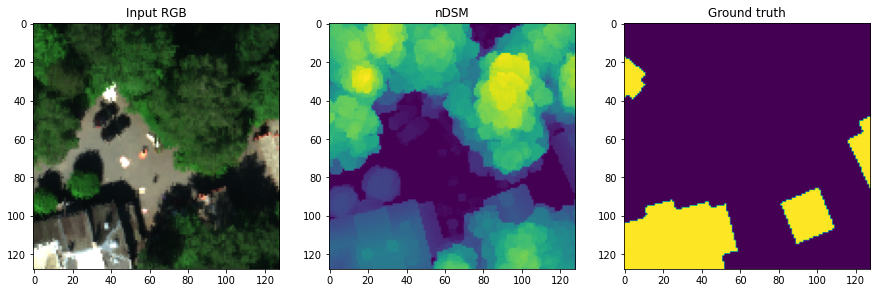

In [40]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,10))

ax1.imshow(np.dstack([X_train[0,:,:,81],X_train[0,:,:,46],X_train[0,:,:,21]])/2500)
ax2.imshow(X_train[0,:,:,-1])
ax3.imshow(y_train[0,:,:].argmax(axis=2))

ax1.set_title("Input RGB")
ax2.set_title("nDSM")
ax3.set_title("Ground truth")
plt.show()

## Weighten the y data

In [41]:
sample_weigths = np.ones((y_train.shape[0], y_train.shape[1], y_train.shape[2],1))
unik = np.unique(y_train.argmax(axis=3), return_counts=True)
y = y_train.argmax(axis=3)

In [42]:
for c,u in zip(unik[0], unik[1]):
  #print(c)
  vekt = (1/(u/sum(unik[1])))**1
  print(f"{classes[c]:18}: {vekt:.5g},\tsamples: {u:7}, andel: {(u/sum(unik[1]))*100:5.4g} %")
  sample_weigths[y[:,:,:] == c] = vekt

None              : 1.1811,	samples: 2358207, andel: 84.67 %
unknown           : 22.563,	samples:  123445, andel: 4.432 %
black concrete    : 25.83,	samples:  107832, andel: 3.871 %
metal roofing     : 96.688,	samples:   28807, andel: 1.034 %
black ceramic     : 211.58,	samples:   13164, andel: 0.4726 %
brown concrete    : 337.57,	samples:    8251, andel: 0.2962 %
red concrete      : 41.994,	samples:   66325, andel: 2.381 %
gravel            : 101.26,	samples:   27507, andel: 0.9876 %
green ceramic     : 896.74,	samples:    3106, andel: 0.1115 %
pcv               : 109.16,	samples:   25515, andel: 0.9161 %
tar roofing paper : 120.47,	samples:   23121, andel: 0.8301 %


## Augmentation on data

In [43]:
def aug_brightness_and_flip(img, label, seed=None):
    rand = np.random.random()*(1.5-.5) + .5
    img = tf.image.adjust_contrast(img, contrast_factor=rand)
    img = tf.image.adjust_brightness(img, delta=rand-1)
    #img = tf.image.adjust_gamma(img, gamma=rand/10)

    if np.random.random() < .5:
      img = tf.image.flip_left_right(img)
      label =tf.image.flip_left_right(label)


    return img, label



In [44]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [45]:
def f(x, y, w):
  seed = rng.make_seeds(2)[0]
  image, label = aug_brightness_and_flip(x, y, seed)
  return image, label, w

In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weigths))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

In [48]:
train_ds = (
    train_dataset
    #.shuffle(1000)
    #.map(f, num_parallel_calls=AUTOTUNE)
    .batch(32)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_dataset
    .batch(32)
    .prefetch(AUTOTUNE)
)

## Set up loss function. Matthews cor and dice

In [49]:
def multi_mcc_loss(y_true, y_pred, false_pos_penal=1.0):
    # Reshape image to flatten form
    y_true = K.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m)))
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    
    return 1 - K.mean(mcc)

## Set up unet and train

In [50]:
all_history = {}

In [51]:
def make_model(loss='categorical_crossentropy'):
  img1 = Input(shape=(128,128,399))

  u = vanilla_unet()
  #K.clear_session()
  #model = None
  model = u.get_unet(img1, None, n_classes=11, last_activation='softmax')

  f1 = tfa.metrics.F1Score(num_classes=11, average='micro')
  model.compile(optimizer='adam',
                loss=loss,
                metrics=[f1])
  return model
  
def train_model(model, train_ds, epochs=100):
  
  earlyStopping = EarlyStopping(monitor='val_f1_score', restore_best_weights=True,
                                patience=15, verbose=1, mode='max')

  h = model.fit( train_ds ,
              #validation_data=val_ds, 
              batch_size=32,
              epochs=epochs,
              verbose=1,
              callbacks=[])
  return h
  

In [52]:
model = make_model(loss=multi_mcc_loss)
h = train_model(model, train_ds, epochs=150)

Epoch 1/150
6/6 [==============================] - 16s 381ms/step - loss: 10.8440 - f1_score: 0.1229
Epoch 2/150
6/6 [==============================] - 2s 301ms/step - loss: 10.5068 - f1_score: 0.2925
Epoch 3/150
6/6 [==============================] - 2s 291ms/step - loss: 10.1829 - f1_score: 0.3541
Epoch 4/150
6/6 [==============================] - 2s 285ms/step - loss: 10.0164 - f1_score: 0.3841
Epoch 5/150
6/6 [==============================] - 2s 289ms/step - loss: 9.8128 - f1_score: 0.4409
Epoch 6/150
6/6 [==============================] - 2s 301ms/step - loss: 9.6229 - f1_score: 0.4818
Epoch 7/150
6/6 [==============================] - 2s 289ms/step - loss: 9.4801 - f1_score: 0.5038
Epoch 8/150
6/6 [==============================] - 2s 294ms/step - loss: 9.3343 - f1_score: 0.5266
Epoch 9/150
6/6 [==============================] - 2s 285ms/step - loss: 9.1890 - f1_score: 0.5509
Epoch 10/150
6/6 [==============================] - 2s 289ms/step - loss: 9.0251 - f1_score: 0.5755
Epoc

In [20]:
# CCE
all_history = {}
hi = []
for _ in range(3):
  model = make_model()
  h = train_model(model, train_ds, epochs=100)
  hi.append(h.history["val_f1_score"])
all_history["cce"] = np.mean(hi, axis=0)

# MCC
hi = []
for _ in range(3):
  model = make_model(multi_mcc_loss)
  h = train_model(model, train_ds, epochs=100)
  hi.append(h.history["val_f1_score"])
all_history["mcc"] = np.mean(hi, axis=0)

In [ ]:
# With weights, Use these up to add weiths!
hi = []
for _ in range(3):
  model = make_model()
  h = train_model(model, train_ds, epochs=100)
  hi.append(h.history["val_f1_score"])
all_history["cce_weights"] = np.mean(hi, axis=0)

# MCC
hi = []
for _ in range(3):
  model = make_model(multi_mcc_loss)
  h = train_model(model, train_ds, epochs=100)
  hi.append(h.history["val_f1_score"])
all_history["mcc_weights"] = np.mean(hi, axis=0)

In [ ]:
all_history

In [ ]:
sns.set_theme()
sns.lineplot(data={modelname:all_history[modelname] for modelname in all_history})
plt.xlabel("epochs"); plt.ylabel("f1")
plt.title("Compare loss function with f1 score")

In [23]:
sns.set_theme()
sns.lineplot(data={modelname:all_history[modelname][70:] for modelname in all_history})
plt.xlabel("epochs"); plt.ylabel("f1")
plt.title("Compare loss function with f1 score")

NameError: ignored

Text(0.5, 1.0, 'with aug')

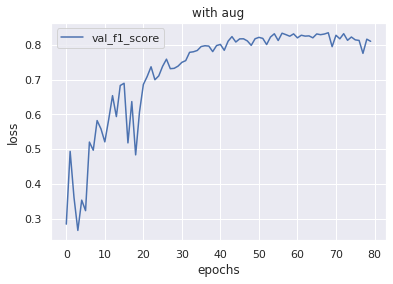

In [24]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][20:]) for key in ['val_f1_score']})
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("with aug")

Text(0.5, 1.0, 'without aug and no weight')

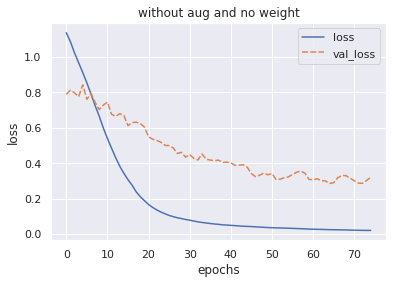

In [96]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][25:]) for key in ['loss', 'val_loss']})
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("without aug and no weight")

Text(0.5, 1.0, 'without aug and weight')

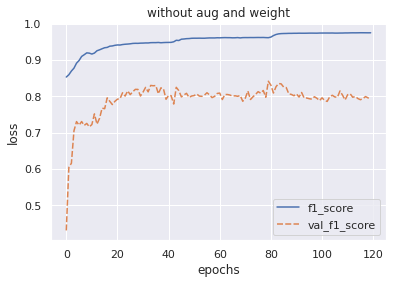

In [126]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][30:]) for key in ['f1_score', 'val_f1_score']})
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("without aug and weight")

## Show predicted area

In [53]:
rød = X_test[:,:,:,81]; grønn = X_test[:,:,:,46]; blå = X_test[:,:,:,21];
rgb = [np.dstack((r,g,b)) for r,g,b in zip(rød,grønn,blå)]
rgb = np.array(rgb)

nx = 6
ny = 4

def arange_image(img):
  u = []
  o = 0
  for i in range(int(nx)):
    b = np.array(img[o])
    o += 1
    for j in range(1,int(ny)):
      b = np.append(b, img[o], axis=1)
      o += 1
                  
    if len(u) == 0:
      u = b
    else:
      u = np.append(u, b, axis=0)
  return u


In [54]:
y = y_test.argmax(axis=3)
pred = model.predict(X_test)
p = np.argmax(pred,axis=3)

u = arange_image(rgb)
v = arange_image(y)
w = arange_image(p)

In [55]:
w[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


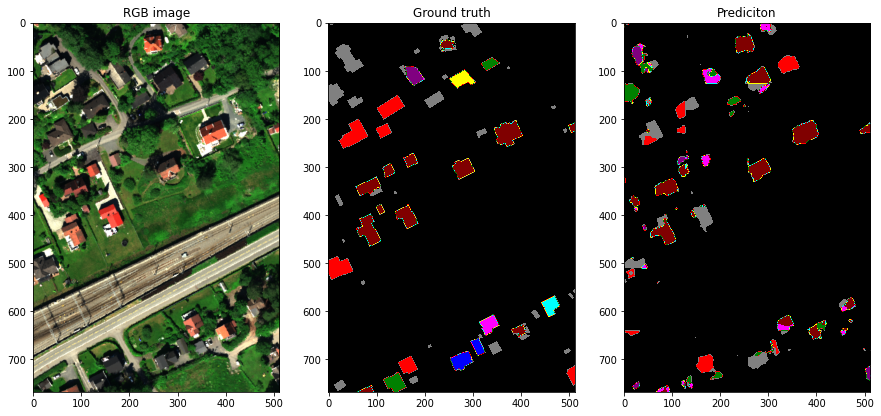

In [56]:
sns.reset_orig()
fig, (ax0, ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
im1 = ax0.imshow(u/2500); ax0.set_title("RGB image")
im1 = ax1.imshow(v, cmap=colormap); ax1.set_title("Ground truth")
im1 = ax2.imshow(w, cmap=colormap); ax2.set_title("Prediciton")

#cbar = fig.colorbar(im1,ticks=[0,1,2,3,4,5,6,7,8,9,10], shrink=0.5)
#cbar.ax.set_yticklabels(classes)
plt.show()

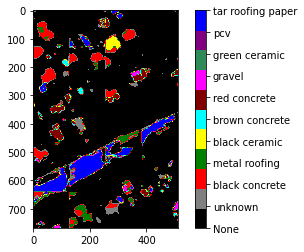

In [62]:
plt.imshow(w, cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10])
cbar.ax.set_yticklabels(classes)
plt.show()

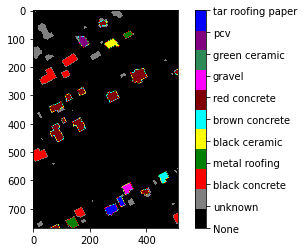

In [43]:
plt.imshow(v, cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10])
cbar.ax.set_yticklabels(classes)
plt.show()

['None',
 'unknown',
 'black concrete',
 'metal roofing',
 'black ceramic',
 'brown concrete',
 'red concrete',
 'gravel',
 'green ceramic',
 'pcv',
 'tar roofing paper']

## Validate data

In [ ]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
                        X_val[x:x+1][0][:,:,46],
                        X_val[x:x+1][0][:,:,21]))/2500)
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_val[x:x+1].argmax(axis=3)[0])
  ax3.set_title("Ground truth")
  pred = model.predict([X_val[x:x+1]]).argmax(axis=3)[0]
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

In [ ]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_test.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
                        X_test[x:x+1][0][:,:,46],
                        X_test[x:x+1][0][:,:,21]))/2500)
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_test[x:x+1].argmax(axis=3)[0])
  ax3.set_title("Ground truth")
  pred = model.predict([X_test[x:x+1]]).argmax(axis=3)[0]
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

In [ ]:
n = 23

plt.imshow(np.dstack([X_test[n,:,:,76], X_test[n,:,:,46], X_test[n,:,:,21]])/2500)
plt.title("Input")
plt.show()

ticks = ["None"]
ticks.extend(['ceramic',
 'concrete',
 'eternit',
 'metal',
 'tar roofing paper'])

colors=mcp.gen_color(cmap="tab10",n=6)
colormap = ListedColormap(colors)

plt.imshow(y_test[n:n+1,:,:,0][0], cmap=colormap)
#cbar = plt.colorbar()
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(ticks)
plt.title("Ground truth")
plt.show()


pred = model.predict(X_test[n:n+1]).argmax(axis=3)[0]
plt.imshow(pred, cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(ticks)
plt.title("Prediction")
plt.show()

In [ ]:

np.min(y_test[1])

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(y_test[23].argmax(axis=2))

# MEtrcis

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_tot = model.predict(X_test)

IndexError: ignored

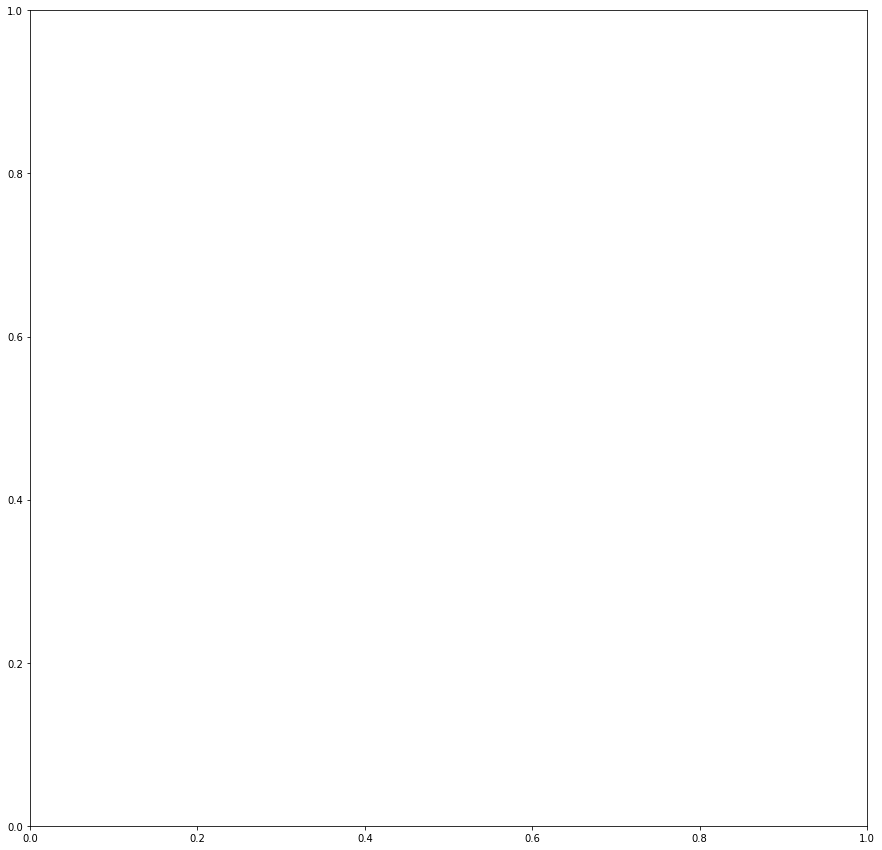

In [36]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(15, 15))

ticks = np.array(ticks)
true = ticks[y_test.argmax(axis=3).flatten()]
pre = ticks[pred_tot.argmax(axis=3).flatten()]

true_ = true[true != "None"]
pre_ = pre[pre != "Noen"]


disp = ConfusionMatrixDisplay.from_predictions(true, pre,
                                        labels=np.unique(ticks),
                                        cmap=plt.cm.Blues,
                                        xticks_rotation=45,
                                        ax=ax,
                                        normalize="true")
ax.set_xticklabels(ax.get_xticklabels() ,ha="right")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true,pre,target_names=ticks))